# **Title:** Austin White Thermal Characterization of Endodontic Obturation Units
## **Author:**  Charles E Taylor, Ph.D. (ctay22@lsuhsc.edu)
**Purpose:** Parse the data that was generated from an ESP32 unit that was programmed with the 'TC_Stream_v2.ino' project and ['StreamingData_v1.ipynb'](https://colab.research.google.com/drive/1KBMengA0cbMJbTt0ZV3bVf4E4T8JBMSm)  



In [1]:
# @title Imports

import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from bokeh.plotting import output_file, show
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.models.tools import HoverTool
from bokeh.plotting import figure as fig
from bokeh.io import output_notebook
from bokeh.layouts import row, column

from scipy import signal
from scipy.stats import tukey_hsd

from sys import getsizeof
import os
import os.path
import pathlib

from scipy import stats
from functools import partial

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from bioinfokit.analys import stat

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
from matplotlib.font_manager import FontProperties
from matplotlib import cm
import matplotlib.colors as mcolors
import dataframe_image as dfi

In [2]:
#PROCESS THE TUKEY-HSD summary table to heatmap table
def TukeyResultsDF(df_THSD):
    
    #cleanup and reformat from 
    
    #Groups
    df_THSD = df_THSD.set_index(['group1','group2'])
    # df_THSD.drop(['Diff','Lower','Upper','q-value'],axis=1,inplace=True)
    df_THSD.drop(['meandiff','lower','upper','reject'], axis=1,inplace=True)
    df_THSD['p-adj']=pd.to_numeric(df_THSD['p-adj'])

    #use xarray to get the pairwise grouping using coordinate system
    ds_THSD = df_THSD.to_xarray()

    #extract coordinates and build DF with coordinates as index and column names
    group1,group2 = ds_THSD.coords.indexes.values()

    #test for comma in group names
    try:
        np.array(group1.to_list()).shape[1]>1
        group1_names = np.array(group1.to_list())
        group1_list = np.char.add(np.char.add(group1_names[:,0],'  '),group1_names[:,1]).tolist()
    except:
        group1_list = group1.to_list()

    try:
        np.array(group2.to_list()).shape[1]>1
        group2_names = np.array(group2.to_list())
        group2_list = np.char.add(np.char.add(group2_names[:,0],'  '),group2_names[:,1]).tolist()
    except:
        group2_list = group2.to_list()


    df_THSD_paired = pd.DataFrame(ds_THSD['p-adj'].values,columns=group2_list)
    df_THSD_paired = pd.concat([df_THSD_paired,pd.DataFrame(group1_list,columns=['Groups'])],axis=1)
    df_THSD_paired.set_index('Groups',inplace=True)

    #sorting
    THSD_NotNan = ~np.isnan(df_THSD_paired.values)
    THSD_rowsum = np.stack((np.sum(THSD_NotNan,axis=1),np.array(group1_list)))
    THSD_colsum = np.stack((np.sum(THSD_NotNan,axis=0),np.array(group2_list)))

    #https://opensourceoptions.com/blog/sort-numpy-arrays-by-columns-or-rows/
    THSD_rowsum = THSD_rowsum[:,THSD_rowsum[0,:].argsort()]
    THSD_colsum = THSD_colsum[:,THSD_colsum[0,:].argsort()[::-1]]

    df_THSD_paired = df_THSD_paired.reindex(THSD_rowsum[1,:])
    df_THSD_paired = df_THSD_paired[THSD_colsum[1,:]] 
    
    return df_THSD_paired

In [76]:
#PLOT THE TUKEY-HSD Heatmap
def TukeyHeatmap(df,titlestr,filestr):

    #organize the data into a comparison table with group1 as index and group 2 as columns
    df_THSDg = TukeyResultsDF(df)

    #seaborn heatmap of the Tukey HSD p-values for GROUPS
    plt.figure(figsize=(7,7))

    cmap_stats = sns.diverging_palette(10, 150, s=50, l=75, n=9)
    divnorm = mcolors.TwoSlopeNorm(vmin=0.001, vcenter=0.05, vmax=0.900)

    #settings for seaborn color bar
    cbar_settings = {'shrink':0.5,
                     'ticks': [.9,.25,.05,.04,1E-3]}

    #sns.set(font_scale=1.0)  # The default is 1.0
    ax_THSD_heat = sns.heatmap(df_THSDg,norm=divnorm,annot=True,fmt=".3f",
                            linewidths=5,cmap=cmap_stats,
                            cbar_kws=cbar_settings, square=True,annot_kws={"size": 18})
    ax_THSD_heat.set_xticklabels(ax_THSD_heat.get_xticklabels(), rotation=15,ha='right', rotation_mode='anchor')
    
    plt.rc('axes',labelsize=10)
    plt.yticks(rotation=0)
    plt.title(titlestr+'\nTukey HSD (Post-Hoc)\nP-Values\n', loc='left', fontsize=18)
    plt.savefig('./THSD_'+filestr+'_pvals.png',bbox_inches='tight',dpi=300)
    plt.show()
    
    return ax_THSD_heat

In [4]:
#IMPORT THE RAW DATA AND BUILD DATA OBJECT TO RECALL FROM

Work_Dir = 'ExperimentalData-JAN2024/Completed Samples/'

DAQ_raw = pathlib.Path.cwd().joinpath(Work_Dir)

print('Location of files: {0}'.format(DAQ_raw))

#get the list of files to import and parse
list_import = list(pathlib.Path(DAQ_raw).rglob('*.csv'))
#list_import = [x for x in list_import if "WaveformLabels" not in x]
#print(list_import)

#read in CSV and create new time column in millisecond format
def build_frame(filename):
    data_import = pd.read_csv(filename)
    data_import['time_ms'] = data_import['time']-data_import['time'][0]
    return data_import

#create dictionary of result dataframes for each CSV
df_dict = {file.stem: build_frame(file) for file in list_import}

Location of files: C:\Users\ctaylor1\OneDrive - LSUHSC\LSUHSC Shared Folders\Endo Research Shared\White - Endo Research\Project - Thermal Characterization\ExperimentalData-JAN2024\Completed Samples


In [5]:
#PLOTTING AND EXAMINATION

#select one dataframe from dictionary to display 
#df = list(df_dict.values())[0]
Trial = 'Woodpecker Fi-G Backfill'
df = df_dict[Trial]

#output_file('TimeLabelingPlot.html')
output_notebook()
p= fig(width=800, height=400)
p.line(x='time_ms', y='data', source=df) 

p.title.text = Trial
#p.title.text = list_import[1].stem
p.xaxis.axis_label = 'Time in ms'
p.yaxis.axis_label = 'Temp in C'

#data to display when hovering over data
#https://programminghistorian.org/en/lessons/visualizing-with-bokeh
hover = HoverTool()
hover.tooltips=[
    ('Index', '$index'),
    ('Time', '@time_ms'),
    ('Temp', '@data'),
]
p.add_tools(hover)


#histogram to help determine peaks
#https://docs.bokeh.org/en/3.1.0/docs/examples/topics/stats/histogram.html
bins = np.linspace(20,440,100)
hist, edges = np.histogram(df['data'],density=True, bins=bins)
p2=fig(width=800, height=400)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white",
         legend_label="Temp Distribution")



show(column(p,p2))

Loading BokehJS ...

In [6]:
#IMPORT A CSV WITH ALL THE DATA LABELS
# COLUMNS: Dataset, Waveform, Start, AscUL, End
# Start = starting index in waveform where heating commences
# AscUL = inflection point index in waveform  when it has heated to plateau/peak
# End = index in waveform when initiating cooling off 

#import label data for timepoints of each dataset
Labels_Dir = 'ExperimentalData-JAN2024/' #relative to notebook
df_labels = pd.read_csv(pathlib.Path.cwd().joinpath(Labels_Dir+'WaveformLabels.csv'))

#mark the backfill versus the downpack units
df_labels['Type'] = df_labels.apply(lambda x: 'Backfill' in x.Dataset, axis=1)

df_labels.head(15)

,Dataset,Waveform,Start,AscUL,End,Type
0,B&L Beta Mini Backfill,1,135,759,1025,True
1,B&L Beta Mini Backfill,2,3425,4006,4652,True
2,B&L Beta Mini Backfill,3,6820,7354,7744,True
3,B&L Beta Mini Backfill,4,9910,10436,10822,True
4,B&L Beta Mini Backfill,5,13228,13778,14256,True
5,B&L Beta Mini Backfill,6,16699,17186,17714,True
6,B&L Beta Mini Backfill,7,20439,20964,21622,True
7,B&L Beta Mini Backfill,8,23854,24364,24862,True
8,B&L Beta Mini Backfill,9,27349,27866,28168,True
9,B&L Beta Mini Backfill,10,30832,31378,31822,True


In [61]:
#calculate the metrics for the assessment

#preallocate the lists
list_max = []
list_slope = []
list_ambient = []
# list_inter = []
df_plot = pd.DataFrame()

#iterate through the labeled waveforms to calculate and arrange plot data
for i in range(0,df_labels.shape[0]):

    #pull the dataset from the dictionary of raw dataframes
    df_sel = df_dict[df_labels['Dataset'][i]]
    
    # Filter the DataFrame up to the threshold
    df_ascending = df_sel.iloc[df_labels['Start'][i]:df_labels['AscUL'][i]]
    
    #fit line to ascending curve
    coefficients = np.polyfit(df_ascending['time_ms'], df_ascending['data'], 1)
    polynomial = np.poly1d(coefficients)

    list_slope.append(polynomial[1]*1000) #convert rise from deg/ms to deg/sec
    # list_inter.append(polynomial[0])
    
    #build the list of max values for that waveform
    df_peakvals = df_sel.iloc[df_labels['AscUL'][i]:df_labels['End'][i]]
    list_max.append(df_peakvals['data'].max())
    
    #calc the ambient temp
    list_ambient.append(df_sel['ambient'].iloc[df_labels['Start'][i]:df_labels['End'][i]].mean())
    
    
    #build plot dataframe
    df_subplot = df_sel.iloc[df_labels['Start'][i]:df_labels['End'][i]]
    df_subplot.reset_index(drop=True, inplace=True)
    
    df_subplot['time_ms'] = df_subplot['time_ms'] - df_subplot['time_ms'][0]
    df_subplot['dataset'] = df_labels['Dataset'][i]
    df_subplot['type'] = df_labels['Type'][i]
    df_subplot['waveform'] = df_labels['Waveform'][i]
    
    df_plot = pd.concat([df_plot,df_subplot],ignore_index=True)
    df_plot.reset_index(drop=True, inplace=True)
    
    #cleanout the subplot dataframe before iteration
    del df_subplot

#convert list to dataframe column 
df_labels['MaxValue']=list_max
df_labels['Rise2Max']=list_slope
df_labels['ambient']=list_ambient
# df_labels['RiseInter']=list_inter

df_labels.head(25)

C:\Users\ctaylor1\AppData\Local\Temp\ipykernel_33244\2010672458.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subplot['time_ms'] = df_subplot['time_ms'] - df_subplot['time_ms'][0]
C:\Users\ctaylor1\AppData\Local\Temp\ipykernel_33244\2010672458.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subplot['dataset'] = df_labels['Dataset'][i]
C:\Users\ctaylor1\AppData\Local\Temp\ipykernel_33244\2010672458.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Dataset,Waveform,Start,AscUL,End,Type,MaxValue,Rise2Max,ambient
0,B&L Beta Mini Backfill,1,135,759,1025,True,134.8750,3.672429,22.970857
1,B&L Beta Mini Backfill,2,3425,4006,4652,True,134.8750,3.398227,22.973258
2,B&L Beta Mini Backfill,3,6820,7354,7744,True,132.6250,3.286406,22.999324
3,B&L Beta Mini Backfill,4,9910,10436,10822,True,132.5625,3.298444,23.004112
4,B&L Beta Mini Backfill,5,13228,13778,14256,True,134.8750,3.323807,22.997203
5,B&L Beta Mini Backfill,6,16699,17186,17714,True,133.3125,3.326784,22.940948
6,B&L Beta Mini Backfill,7,20439,20964,21622,True,133.1875,3.421015,22.835746
7,B&L Beta Mini Backfill,8,23854,24364,24862,True,134.6875,3.225813,22.789807
8,B&L Beta Mini Backfill,9,27349,27866,28168,True,134.5625,3.219250,22.682921
9,B&L Beta Mini Backfill,10,30832,31378,31822,True,131.5000,3.056030,22.645076


Tukey-HSD to test pairwise differences for Downpack Units
----------------------------------------------------------
MaxValue
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
       group1                 group2           meandiff p-adj   lower     upper   reject
----------------------------------------------------------------------------------------
  B&L Alpha Downpack     Elements iC Downpack   187.458   0.0  162.7506  212.1653   True
  B&L Alpha Downpack Woodpecker Fi-P Downpack   33.5398 0.005    9.4279   57.6517   True
Elements iC Downpack Woodpecker Fi-P Downpack -153.9182   0.0 -178.6255 -129.2108   True
----------------------------------------------------------------------------------------
---
 


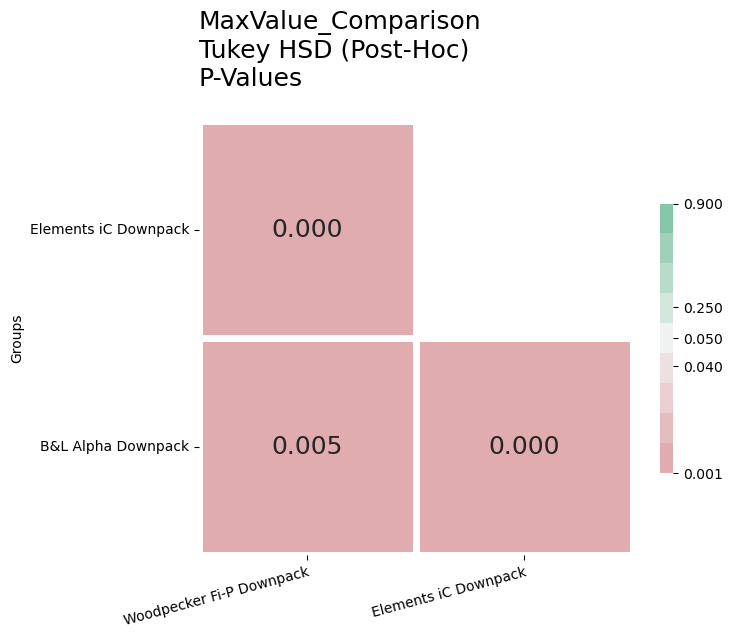

Tukey-HSD to test pairwise differences for Downpack Units
----------------------------------------------------------
RiseTime
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1                 group2          meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------------------
  B&L Alpha Downpack     Elements iC Downpack 132.0104   0.0  97.6761 166.3447   True
  B&L Alpha Downpack Woodpecker Fi-P Downpack  97.6739   0.0  64.1671 131.1808   True
Elements iC Downpack Woodpecker Fi-P Downpack -34.3365  0.05 -68.6707  -0.0022   True
-------------------------------------------------------------------------------------
---
 


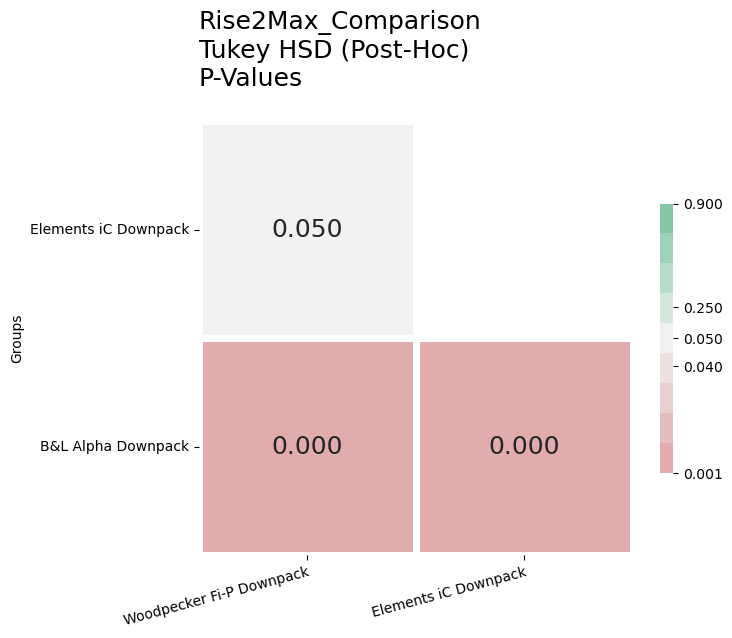

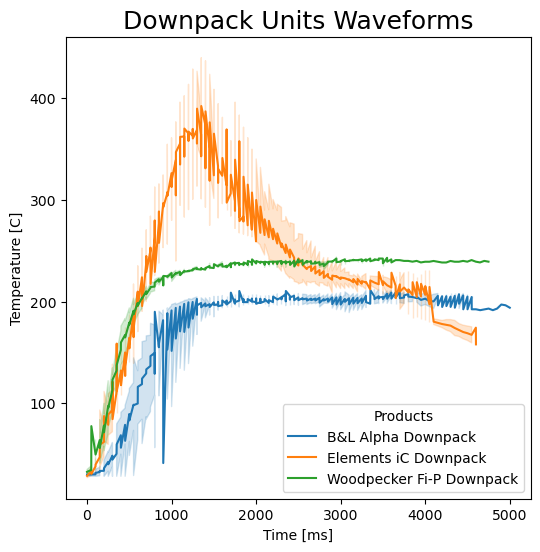

In [77]:
#statistical work on Downpack units

df_downpack = df_labels.query('Type == False')

print('Tukey-HSD to test pairwise differences for Downpack Units')
print('----------------------------------------------------------')
tukey = pairwise_tukeyhsd(endog=df_downpack['MaxValue'],groups=df_downpack['Dataset'],alpha=0.05)
print('MaxValue')
print(tukey)
print('---')
print(' ')

df_THSD = pd.DataFrame(tukey._results_table.data) #pull table that is below title bar
df_THSD.columns = df_THSD.iloc[0] #set column names to the values of first row
df_THSD.drop(0, inplace=True) #drop the first row that had column names

ax_THSD_max = TukeyHeatmap(df_THSD,('MaxValue_Comparison'),('Downpack_maxvalue_HSD'))


print('Tukey-HSD to test pairwise differences for Downpack Units')
print('----------------------------------------------------------')
tukey = pairwise_tukeyhsd(endog=df_downpack['Rise2Max'],groups=df_downpack['Dataset'],alpha=0.05)
print('RiseTime')
print(tukey)
print('---')
print(' ')

df_THSD = pd.DataFrame(tukey._results_table.data) #pull table that is below title bar
df_THSD.columns = df_THSD.iloc[0] #set column names to the values of first row
df_THSD.drop(0, inplace=True) #drop the first row that had column names

ax_THSD_rise = TukeyHeatmap(df_THSD,('Rise2Max_Comparison'),('Downpack_Rise2Max_HSD'))


# Set up the waveform overlay plot
plt.figure(figsize=(6, 6))

#pull out the downpack units data 
df_plotting = df_plot.query('type == False')

# Plot lineplot with hue (grouped by 'species') and style (different shades)
sns.lineplot(x='time_ms', y='data', hue='dataset', data=df_plotting)

# Show the legend
plt.legend(title="Products",loc='lower right')
plt.xlabel('Time [ms]')
plt.ylabel('Temperature [C]')
plt.title('Downpack Units Waveforms', fontsize=18)
plt.savefig('./Downpack_Waveforms.png',bbox_inches='tight',dpi=300)

# Display the plot
plt.show()

Tukey-HSD to test pairwise differences for Backfill Units
----------------------------------------------------------
MaxValue
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
         group1                   group2          meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------------
  B&L Beta Mini Backfill     Elements iC Backfill -13.4335    0.0 -18.1433  -8.7238   True
  B&L Beta Mini Backfill Woodpecker Fi-E Backfill -43.8256    0.0 -48.5353 -39.1158   True
  B&L Beta Mini Backfill Woodpecker Fi-G Backfill -44.6188    0.0 -49.4394 -39.7981   True
    Elements iC Backfill Woodpecker Fi-E Backfill  -30.392    0.0 -34.9883 -25.7958   True
    Elements iC Backfill Woodpecker Fi-G Backfill -31.1852    0.0  -35.895 -26.4755   True
Woodpecker Fi-E Backfill Woodpecker Fi-G Backfill  -0.7932 0.9688   -5.503   3.9166  False
-------------------------------------------------------

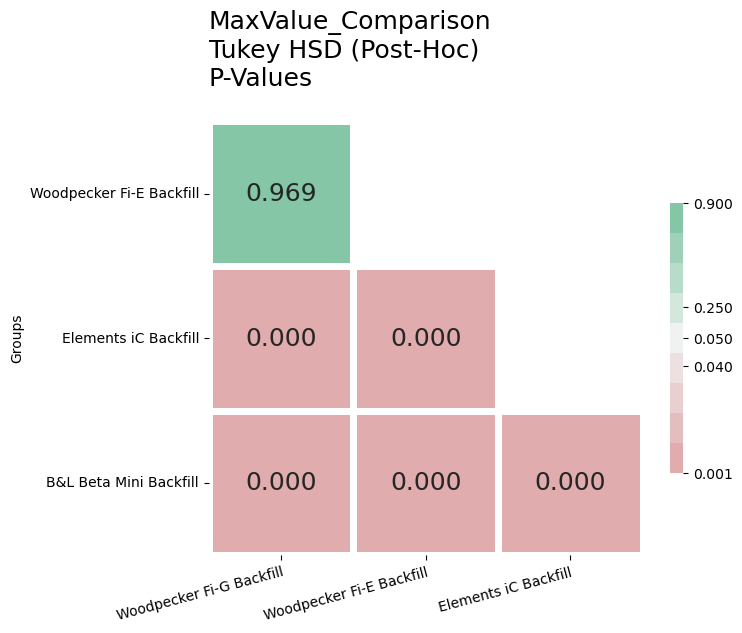

Tukey-HSD to test pairwise differences for Backfill Units
----------------------------------------------------------
RiseTime
                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
         group1                   group2          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------
  B&L Beta Mini Backfill     Elements iC Backfill  -0.7614    0.0 -1.0119 -0.5109   True
  B&L Beta Mini Backfill Woodpecker Fi-E Backfill  -1.6227    0.0 -1.8732 -1.3722   True
  B&L Beta Mini Backfill Woodpecker Fi-G Backfill  -1.3876    0.0  -1.644 -1.1312   True
    Elements iC Backfill Woodpecker Fi-E Backfill  -0.8613    0.0 -1.1058 -0.6169   True
    Elements iC Backfill Woodpecker Fi-G Backfill  -0.6263    0.0 -0.8768 -0.3758   True
Woodpecker Fi-E Backfill Woodpecker Fi-G Backfill   0.2351 0.0726 -0.0154  0.4856  False
-------------------------------------------------------------------------

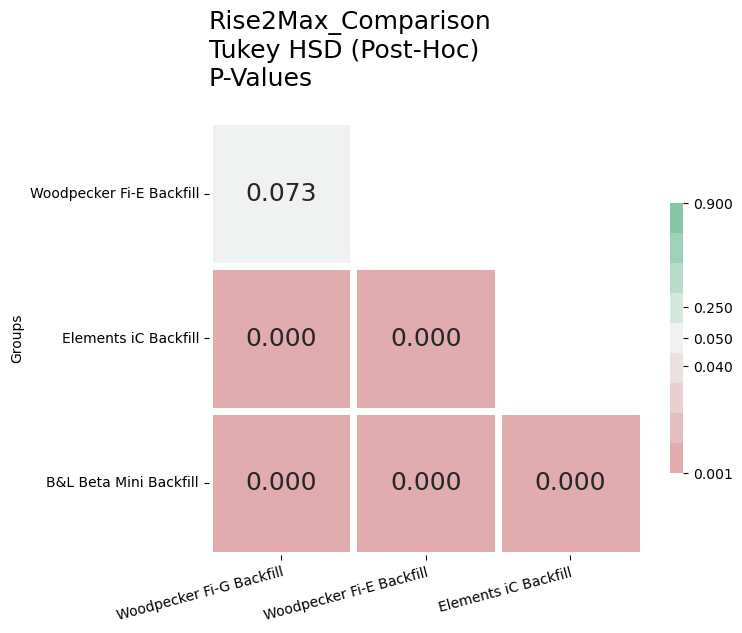

In [ ]:
#statistical work on backfill units

df_backfill = df_labels.query('Type == True')

print('Tukey-HSD to test pairwise differences for Backfill Units')
print('----------------------------------------------------------')
tukey = pairwise_tukeyhsd(endog=df_backfill['MaxValue'],groups=df_backfill['Dataset'],alpha=0.05)
print('MaxValue')
print(tukey)
print('---')
print(' ')

df_THSD = pd.DataFrame(tukey._results_table.data) #pull table that is below title bar
df_THSD.columns = df_THSD.iloc[0] #set column names to the values of first row
df_THSD.drop(0, inplace=True) #drop the first row that had column names

TukeyHeatmap(df_THSD,('MaxValue_Comparison'),('Backfill_maxvalue_HSD'))


print('Tukey-HSD to test pairwise differences for Backfill Units')
print('----------------------------------------------------------')
tukey = pairwise_tukeyhsd(endog=df_backfill['Rise2Max'],groups=df_backfill['Dataset'],alpha=0.05)
print('RiseTime')
print(tukey)
print('---')
print(' ')

df_THSD = pd.DataFrame(tukey._results_table.data) #pull table that is below title bar
df_THSD.columns = df_THSD.iloc[0] #set column names to the values of first row
df_THSD.drop(0, inplace=True) #drop the first row that had column names

TukeyHeatmap(df_THSD,('Rise2Max_Comparison'),('Backfill_Rise2Max_HSD'))


# Set up the waveform overlay plot
plt.figure(figsize=(6, 6))

df_plotting = df_plot.query('type == True').iloc[::2]

# Plot lineplot with hue (grouped by 'species') and style (different shades)
sns.lineplot(x='time_ms', y='data', hue='dataset', data=df_plotting, linewidth=.5)

# Show the legend
plt.legend(title="Products",loc='lower right')
plt.xlabel('Time [ms]')
plt.ylabel('Temperature [C]')
plt.title('Backfill Units Waveforms', fontsize=18)
plt.savefig('./Backfill_Waveforms.png',bbox_inches='tight',dpi=300)

# Display the plot
plt.show()

ANOVA for Downpack Units Max Temperature
                   sum_sq    df           F        PR(>F)
C(Dataset)  206486.154210   2.0  196.926948  1.333555e-17
Residual     15203.857386  29.0         NaN           NaN
 
ANOVA for Downpack Units Heating Rate
                   sum_sq    df          F        PR(>F)
C(Dataset)  100031.100212   2.0  49.402115  4.569463e-10
Residual     29360.098589  29.0        NaN           NaN
 
ANOVA for Backfill Units Heating Rate
               sum_sq    df          F        PR(>F)
C(Dataset)  16.308282   3.0  119.35703  2.176208e-19
Residual     1.730703  38.0        NaN           NaN
 
ANOVA for Backfill Units Heating Rate
               sum_sq    df          F        PR(>F)
C(Dataset)  16.308282   3.0  119.35703  2.176208e-19
Residual     1.730703  38.0        NaN           NaN
 
ANOVA for Ambient Temperature Across All Experiments
                   sum_sq       df             F  PR(>F)
C(dataset)  735836.858248      6.0  5.148978e+06     0.0
Residua

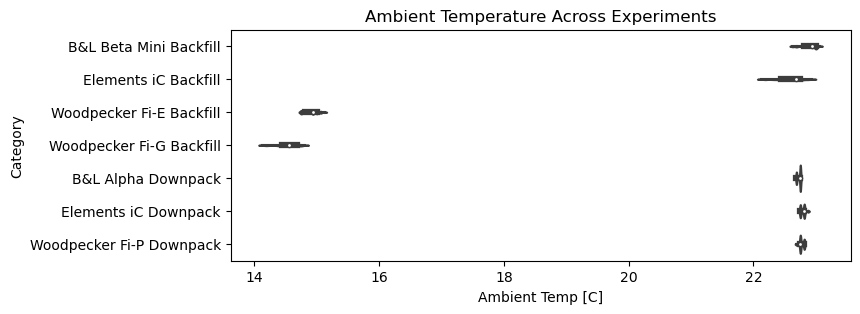

2-Way ANOVA for Backfill Units and Ambient Effect on Heating Rate
                      sum_sq    df          F        PR(>F)
C(Dataset)          3.238232   3.0  27.176721  3.764057e-09
ambient             0.024091   1.0   0.606547  4.414779e-01
C(Dataset):ambient  0.356193   3.0   2.989335  4.453504e-02
Residual            1.350419  34.0        NaN           NaN
 
2-Way ANOVA for Backfill Units and Ambient Effect on the Max Temperature
                        sum_sq    df          F        PR(>F)
C(Dataset)          819.858414   3.0  38.807517  4.423253e-11
ambient             141.281475   1.0  20.062427  8.046823e-05
C(Dataset):ambient  231.060630   3.0  10.937119  3.526671e-05
Residual            239.431154  34.0        NaN           NaN
 


In [74]:
## ANOVA analysis 

model = ols('MaxValue ~ C(Dataset)', data=df_downpack).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA for Downpack Units Max Temperature')
print(anova_table)
print(' ')

model = ols('Rise2Max ~ C(Dataset)', data=df_downpack).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA for Downpack Units Heating Rate')
print(anova_table)
print(' ')

model = ols('Rise2Max ~ C(Dataset)', data=df_backfill).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA for Backfill Units Heating Rate')
print(anova_table)
print(' ')

model = ols('Rise2Max ~ C(Dataset)', data=df_backfill).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA for Backfill Units Heating Rate')
print(anova_table)
print(' ')

model = ols('ambient ~ C(dataset)', data=df_plot).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('ANOVA for Ambient Temperature Across All Experiments')
print(anova_table)
print(' ')

#Get the descriptive stats on the ambient temp
print('Ambient Temperature Descriptive Stats')
print(df_plot['ambient'].describe())

#plot the ambient temperatures across the datasets
plt.figure(figsize=(8, 3))
ax_violin = sns.violinplot(y='dataset', x='ambient',  data=df_plot)
plt.xlabel('Ambient Temp [C]')
plt.ylabel('Category')
plt.title('Ambient Temperature Across Experiments')
plt.show()

#Perform a 2-way ANOVA to test for the effect of ambient temperature on the Rise2Max
model = ols('Rise2Max ~ C(Dataset) + ambient + C(Dataset):ambient', data=df_backfill).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('2-Way ANOVA for Backfill Units and Ambient Effect on Heating Rate')
print(anova_table)
print(' ')

#Perform a 2-way ANOVA to test for the effect of ambient temperature on the MaxValue
model = ols('MaxValue ~ C(Dataset) + ambient + C(Dataset):ambient', data=df_backfill).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print('2-Way ANOVA for Backfill Units and Ambient Effect on the Max Temperature')
print(anova_table)
print(' ')

In [25]:
#troubleshooting waveform plots
# Trying to figure out which waveform had incorrect start index

mask = df_plot['dataset'].isin(['Woodpecker Fi-G Backfill'])
df_trouble=df_plot[mask].query('waveform == 8')
#query('type == True').query('waveform == 5').query('dataset == 'Woodpecker Fi-G Backfill'')

output_notebook()
p5= fig(width=800, height=400)
p5.line(x='time_ms', y='data', source=df_trouble) 

p5.title.text = Trial
#p5.title.text = list_import[1].stem
p5.xaxis.axis_label = 'Time in ms'
p5.yaxis.axis_label = 'Temp in C'

#data to display when hovering over data
#https://programminghistorian.org/en/lessons/visualizing-with-bokeh
hover = HoverTool()
hover.tooltips=[
    ('Index', '$index'),
    ('Time', '@time_ms'),
    ('Temp', '@data'),
]

p5.add_tools(hover)

show(p5)

Loading BokehJS ...

In [17]:
#Previous code

#used to determine ascending and peak sections by only having the starting points of the waveform

#     #sort by action if it is at the end of the dataset or the last waveform number
#     if i == (df_labels.shape[0]-1):
#         df_waveform = df_sel[['time_ms','data']].iloc[df_labels['Start'].iloc[i]:]
    
#     #not the end of the dataset
#     else:       
#         if df_labels['Waveform'][i+1] < df_labels['Waveform'][i]:
#             df_waveform = df_sel[['time_ms','data']].iloc[df_labels['Start'].iloc[i]:]
            
#         else: 
#             df_waveform = df_sel[['time_ms','data']].iloc[df_labels['Start'].iloc[i]:df_labels['Start'].iloc[i+1]]
        
#     #build the list of max values for that waveform    
#     #list_max.append(df_waveform['data'].max())
    
#     #find the slope of the anachrotic limb
#     # Find the index of the first occurrence of the value
#     threshold = df_waveform['data'].max() * 0.90

#     # Create a boolean mask where values are less than or equal to the threshold
#     mask = df_waveform['data'] > threshold

#     # Find the index of the first occurrence where the value exceeds the threshold
#     first_exceed_index = mask.idxmax() if not mask.all() else len(df_waveform)